In [4]:
import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
mat = scipy.io.loadmat('spamData.mat')


In [5]:
# Log-transform of features
Xtrain_log = np.log(mat["Xtrain"] + 0.1)
Xtest_log = np.log(mat["Xtest"] + 0.1)

# Binarization of geatures
Xtrain_binary = (mat["Xtrain"] > 0).astype(int)
Xtest_binary = (mat["Xtest"] > 0).astype(int)

In [6]:
# Class label prior, feature likelihood using posterior predictive. 
# For spam mail, we figure out what N and N(j) is, where j is the feature number.
# N equals to spam_count, N(j) can be found by iterating through the rows of binarized data where ytrain = 1
# While computing number of spam emails, we also find out the row numbers of rows of spam mail.

spam_bin = []
notspam_bin = []

for i in range (len(mat["ytrain"])):
    if mat["ytrain"][i] == 0:
        notspam_bin.append(Xtrain_binary[i])
    else:
        spam_bin.append(Xtrain_binary[i])
        
classlabelprior = len(spam_bin)/len(mat["ytrain"])
  
# Storing of N(j) for spam mail
spam_feature = np.sum(spam_bin, axis = 0)
           
# Storing of N(j) for not spam mail
notspam_feature = np.sum(notspam_bin, axis = 0)

spam_count = len(spam_bin)
notspam_count = len(mat["ytrain"]) - spam_count

In [ ]:
beta = 0
y_predict = []
beta_accuracy = []

# Test error
while (beta != 100.5):

    for i in range (len(Xtest_binary)):
        # Computing the class prior
        spam_likelihood= np.log(classlabelprior)
        notspam_likelihood = np.log(1-classlabelprior)

        for j in range (len(Xtest_binary[i])):

            if Xtest_binary[i][j] == 1:
                spam_likelihood += math.log((spam_feature[j]+beta)/(spam_count+(2*beta)))
                notspam_likelihood += math.log((notspam_feature[j]+beta)/(notspam_count+2*beta))
            else:
                spam_likelihood += math.log(1-((spam_feature[j]+beta)/(spam_count+2*beta)))
                notspam_likelihood += math.log(1-((notspam_feature[j]+beta)/(notspam_count+2*beta)))

        # Actual prediction of class label
        y_predict.append((spam_likelihood > notspam_likelihood).astype(int))
    
    a = np.reshape(y_predict,(1536,1)) # Changing shape so that matrix subtraction is accurate

    beta_accuracy.append(np.mean(abs(mat["ytest"]-a)))
    y_predict = [] # Resetting the array that stores predicted class labes for next beta parameter
    beta += 0.5 # Changing beta parameter


# Train error. For some reason, this part is absurdly slow (5-10 minutes) to run. 
# It probably has to do with the fact that there are too many elements, and time complexity is O(N^3)? I can't think of a faster way to implement this, sadly.
# For proof of concept, you can run algorithm for test error.
beta = 0
ytrain_predict = []
trainbeta_accuracy = []
while (beta != 100.5):

    for i in range (len(Xtrain_binary)):
        spam_likelihood= np.log(classlabelprior)
        notspam_likelihood = np.log(1-classlabelprior)

        for j in range (len(Xtrain_binary[i])):

            if Xtrain_binary[i][j] == 1:
                spam_likelihood += math.log((spam_feature[j]+beta)/(spam_count+(2*beta)))
                notspam_likelihood += math.log((notspam_feature[j]+beta)/(notspam_count+2*beta))
            else:
                spam_likelihood += math.log(1-((spam_feature[j]+beta)/(spam_count+2*beta)))
                notspam_likelihood += math.log(1-((notspam_feature[j]+beta)/(notspam_count+2*beta)))


        ytrain_predict.append((spam_likelihood > notspam_likelihood).astype(int))
    
    a = np.reshape(ytrain_predict,(3065,1))

    trainbeta_accuracy.append(np.mean(abs(mat["ytrain"]-a)))
    ytrain_predict = []
    beta += 0.5
    
# Plot 
beta = np.arange(0,100.5,0.5)
plt.plot(beta,beta_accuracy, label = 'Test error')
plt.plot(beta,trainbeta_accuracy, label= 'Train error', color = 'red')
plt.xlabel('Value of beta', fontsize=14)
plt.ylabel('Error rate', fontsize=14)
plt.title('Plot of test and training errors against beta', fontsize = 14, loc='center')
plt.legend(loc='best',prop={'size': 12})
plt.show()

In [11]:
# Gaussian
y_predict = []
spam_log = []
notspam_log = []

# Creating Normal pdf function
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

# Test error
for i in range (len(mat["ytrain"])):
    if mat["ytrain"][i] == 1:
        spam_log.append(Xtrain_log[i])
    else:
        notspam_log.append(Xtrain_log[i])      

# Mean and variance of spam/non-spam features in training set
spam_mean_array = np.mean(spam_log, axis = 0)
spam_variance_array = np.mean((spam_log - spam_mean_array)**2, axis = 0)

notspam_mean_array = np.mean(notspam_log, axis = 0)
notspam_variance_array = np.mean((notspam_log - notspam_mean_array)**2, axis = 0)

for i in range (len(Xtest_log)):
    spam_likelihood= np.log(classlabelprior)
    notspam_likelihood = np.log(1-classlabelprior)

    for j in range (len(Xtest_log[i])):
        spam_likelihood += np.log(normpdf(Xtest_log[i][j],spam_mean_array[j],spam_variance_array[j]**0.5))
        notspam_likelihood += np.log(normpdf(Xtest_log[i][j],notspam_mean_array[j],notspam_variance_array[j]**0.5))

    y_predict.append((spam_likelihood > notspam_likelihood).astype(int))

gaussian_accuracy = np.mean(abs(mat["ytest"]-np.reshape(y_predict,(1536,1))))
print("Test error is ",gaussian_accuracy)

ytrain_predict = []

# Train error
for i in range (len(Xtrain_log)):
    spam_likelihood= np.log(classlabelprior)
    notspam_likelihood = np.log(1-classlabelprior)

    for j in range (len(Xtrain_log[i])):
        spam_likelihood += np.log(normpdf(Xtrain_log[i][j],spam_mean_array[j],spam_variance_array[j]**0.5))
        notspam_likelihood += np.log(normpdf(Xtrain_log[i][j],notspam_mean_array[j],notspam_variance_array[j]**0.5))

    ytrain_predict.append((spam_likelihood > notspam_likelihood).astype(int))

gaussian_accuracy = np.mean(abs(mat["ytrain"]-np.reshape(ytrain_predict,(3065,1))))
print("Traning error is ",gaussian_accuracy)

<ipython-input-11-9d93a3e59052>:32: RuntimeWarning: divide by zero encountered in log
  spam_likelihood += np.log(normpdf(Xtest_log[i][j],spam_mean_array[j],spam_variance_array[j]**0.5))
<ipython-input-11-9d93a3e59052>:33: RuntimeWarning: divide by zero encountered in log
  notspam_likelihood += np.log(normpdf(Xtest_log[i][j],notspam_mean_array[j],notspam_variance_array[j]**0.5))


Test error is  0.18359375


<ipython-input-11-9d93a3e59052>:48: RuntimeWarning: divide by zero encountered in log
  spam_likelihood += np.log(normpdf(Xtrain_log[i][j],spam_mean_array[j],spam_variance_array[j]**0.5))
<ipython-input-11-9d93a3e59052>:49: RuntimeWarning: divide by zero encountered in log
  notspam_likelihood += np.log(normpdf(Xtrain_log[i][j],notspam_mean_array[j],notspam_variance_array[j]**0.5))


Traning error is  0.166721044045677


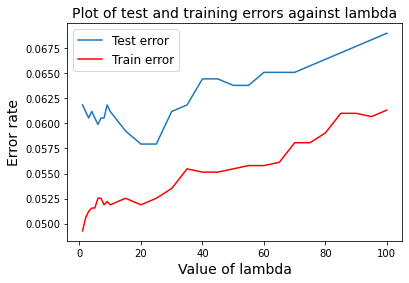

In [9]:
# Logistic Regression

# Test error

w = np.zeros((58,1))

# List of lambda values
lam = np.concatenate((np.arange(1,10),np.arange(10,105,5)))

# Biasing our training data
b = np.ones((len(Xtrain_log), 1))
c = np.concatenate((b,Xtrain_log), axis = 1)
difference = 1
final = []

for i in lam:
    while(difference) > 1e-12:

        mu = 1 / (1+(np.exp(-c@w)))
        nobias_w = np.copy(w)
        nobias_w[0] = 0 #Biasing our weight vector
        g_reg = (np.transpose(c) @ (mu-mat["ytrain"])) + (i * nobias_w) # Calculation of biased gradient

        s = np.diagflat(mu * (1 -mu))
        h_reg_bias = np.identity(58)
        h_reg_bias[0][0] = 0
        h_reg = (np.transpose(c) @ s @ c) + (i * h_reg_bias) # Calculation of biased hessian
        h_inv = np.linalg.inv(h_reg)

        w = w - (h_inv @ g_reg)
        difference = np.sum(np.abs(np.matmul(h_inv,g_reg)))    

    # Biasing our test data
    d = np.ones((len(Xtest_log), 1))
    e = np.concatenate((d,Xtest_log), axis = 1)

    mu_test = 1 / (1 + np.exp(-e @ w))
    prediction = (mu_test > 0.5).astype(int)
    final.append(np.mean(abs(mat["ytest"]-prediction)))
    difference = 1

# Training error   
 
w = np.zeros((58,1))

lam = np.concatenate((np.arange(1,10),np.arange(10,105,5)))

b = np.ones((len(Xtrain_log), 1))
c = np.concatenate((b,Xtrain_log), axis = 1)
difference = 1
train_final = []

for i in lam:
    while(difference) > 1e-12:

        mu = 1 / (1+(np.exp(-c@w)))
        nobias_w = np.copy(w)
        nobias_w[0] = 0
        g_reg = (np.transpose(c) @ (mu-mat["ytrain"])) + (i * nobias_w)

        s = np.diagflat(mu * (1 -mu))
        h_reg_bias = np.identity(58)
        h_reg_bias[0][0] = 0
        h_reg = (np.transpose(c) @ s @ c) + (i * h_reg_bias)
        h_inv = np.linalg.inv(h_reg)

        w = w - (h_inv @ g_reg)
        difference = np.sum(np.abs(np.matmul(h_inv,g_reg)))    

    d = np.ones((len(Xtrain_log), 1))
    e = np.concatenate((d,Xtrain_log), axis = 1)

    mu_test = 1 / (1 + np.exp(-e @ w))
    prediction = (mu_test > 0.5).astype(int)
    train_final.append(np.mean(abs(mat["ytrain"]-prediction)))
    difference = 1    
      
# Plot 
plt.plot(lam,final, label = 'Test error')
plt.plot(lam,train_final, label= 'Train error', color = 'red')
plt.xlabel('Value of lambda', fontsize=14)
plt.ylabel('Error rate', fontsize=14)
plt.title('Plot of test and training errors against lambda', fontsize = 14, loc='center')
plt.legend(loc='best',prop={'size': 12})
plt.show()


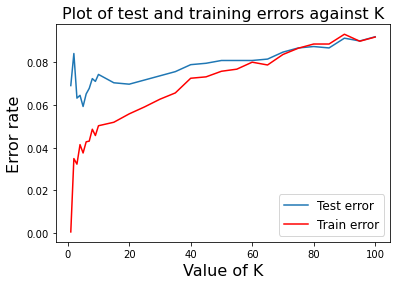

In [10]:
#K-Nearest Neighbour

# Test error
# Preparing our data for matrix multiplication, method is inspired from: https://mlxai.github.io/2017/01/03/finding-distances-between-data-points-with-numpy.html
a = np.reshape(np.sum(Xtest_log**2, axis = 1), (len(Xtest_log),1))
b = np.sum(Xtrain_log**2, axis = 1)
c = a + b - (2*(Xtest_log@np.transpose(Xtrain_log))) # This is the table where euclidean distance between each point of test data is compared with every point in our training data

# Creating list of K values
k = np.concatenate((np.arange(1,10),np.arange(10,105,5)))
test_acc = []
for j in k:
    d = []
    for i in range(len(c)):
        y = np.argpartition(c[i],j)[:j] # This returns the index of K nearest points
        y = np.ndarray.tolist(y) # Numpy array contains data type that is not consistent with other arrays, this converts the data type to an appropriate one
        d.append(y)

    e = mat["ytrain"][d]
    e = (np.sum(e, axis = 1)/j) #By summing the number of ones in a row and dividing by K, if this value is >= 0.5, there are more 1s than 0s, and vice versa
    f = (e>0.5).astype(int) # Converting true/false to 1/0
    f = np.ndarray.tolist(f) # Again, converting data type to appropriate one
    test_acc.append(np.mean(abs((mat["ytest"]-f))))
    
# Train error
a = np.reshape(np.sum(Xtrain_log**2, axis = 1), (len(Xtrain_log),1))
b = np.sum(Xtrain_log**2, axis = 1)
c = a + b - (2*(Xtrain_log@np.transpose(Xtrain_log)))

k = np.concatenate((np.arange(1,10),np.arange(10,105,5)))
train_acc = []
for j in k:
    d = []
    for i in range(len(c)):
        y = np.argpartition(c[i],j)[:j]
        y = np.ndarray.tolist(y)
        d.append(y)

    e = mat["ytrain"][d]
    e = (np.sum(e, axis = 1)/j) 
    f = (e>0.5).astype(int)
    f = np.ndarray.tolist(f)
    train_acc.append(np.mean(abs((mat["ytrain"]-f))))
      
# Plot
plt.plot(k,test_acc, label = 'Test error')
plt.plot(k,train_acc, label= 'Train error', color = 'red')
plt.xlabel('Value of K', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('Plot of test and training errors against K', fontsize = 16, loc='center')
plt.legend(loc='best',prop={'size': 12})
plt.show()